In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Carregamento dos Dados ---
print("Carregando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# Para esta primeira abordagem de LSTM, usaremos um modelo univariado (apenas o pH)
# para mantermos a simplicidade e seguirmos o livro.
ph_series = df['ph'].values.reshape(-1, 1)

# --- 2. Normalização dos Dados ---
print("Normalizando os dados...")
scaler = MinMaxScaler(feature_range=(0, 1))
ph_scaled = scaler.fit_transform(ph_series)

# --- 3. Divisão Treino-Teste ---
# Usaremos a mesma divisão que nos deu os melhores resultados
train_size = len(ph_scaled) - (7 * 24 * 3)
train_data = ph_scaled[:train_size]
test_data = ph_scaled[train_size:]

# --- 4. Função para Criar Sequências ---
def create_sequences(input_data, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        # A sequência de entrada (X) é uma janela de 'sequence_length' pontos
        X.append(input_data[i:(i + sequence_length)])
        # O alvo (y) é o ponto imediatamente seguinte à janela
        y.append(input_data[i + sequence_length])
    return np.array(X), np.array(y)

# --- 5. Criação dos Datasets Finais ---
# Vamos usar uma janela de 24 horas (72 pontos) como nossa sequência de entrada
sequence_length = 72 

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# --- 6. Conversão para Tensores do PyTorch ---
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

print("\nDados preparados e transformados em sequências para a LSTM.")
print(f"Formato de X_train (amostras, comprimento da sequência, features): {X_train.shape}")
print(f"Formato de y_train (amostras, features): {y_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print(f"Formato de y_test: {y_test.shape}")

Carregando os dados...
Normalizando os dados...

Dados preparados e transformados em sequências para a LSTM.
Formato de X_train (amostras, comprimento da sequência, features): torch.Size([4536, 72, 1])
Formato de y_train (amostras, features): torch.Size([4536, 1])
Formato de X_test: torch.Size([432, 72, 1])
Formato de y_test: torch.Size([432, 1])


In [2]:
# --- 7. Definição da Arquitetura do Modelo LSTM ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        # Camada LSTM: processa a sequência de entrada
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        
        # Camada Linear: transforma a saída da LSTM na previsão final
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        # Célula de memória e estado oculto inicial (não é aprendida)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        # A entrada para a LSTM deve ter o formato (comprimento_sequencia, batch_size, features)
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        # Pegamos apenas a saída do último passo da sequência e a passamos para a camada linear
        predictions = self.linear(lstm_out.view(len(input_seq), -1)[-1])
        return predictions

# --- 8. Treinamento do Modelo ---
print("\nIniciando o treinamento do modelo LSTM...")

# Instanciar o modelo, a função de perda e o otimizador
model = LSTMModel()
loss_function = nn.MSELoss() # Erro Quadrático Médio é comum para treino de regressão
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loop de treino
epochs = 150
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if (i+1)%25 == 0:
        print(f'Época {i+1}/{epochs} - Perda (Loss): {single_loss.item():.4f}')

print("Treinamento concluído.")

# --- 9. Avaliação no Conjunto de Teste ---
print("\nIniciando a avaliação no conjunto de teste...")
model.eval()
test_predictions = []

for i in range(len(X_test)):
    seq = X_test[i]
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        test_predictions.append(model(seq).item())

# Reverter a normalização para comparar com os valores reais
true_values = scaler.inverse_transform(y_test.numpy())
predicted_values = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Calcular o MAE
mae_lstm = mean_absolute_error(true_values, predicted_values)
print(f"\n--- Resultados do Modelo LSTM ---")
print(f"MAE Final no Conjunto de Teste: {mae_lstm:.4f}")

# --- 10. Visualização ---
plt.figure(figsize=(15, 6))
plt.title('Previsão LSTM vs. Valores Reais')
plt.ylabel('pH Value')
plt.xlabel('Time Step')
plt.grid(True)
plt.plot(true_values, label='Valores Reais', color='gray')
plt.plot(predicted_values, label='Previsão LSTM', color='red', linestyle='--')
plt.legend()
plt.show()


Iniciando o treinamento do modelo LSTM...
Época 25/150 - Perda (Loss): 0.0002
Época 50/150 - Perda (Loss): 0.0003
Época 75/150 - Perda (Loss): 0.0002
Época 100/150 - Perda (Loss): 0.0002
Época 125/150 - Perda (Loss): 0.0000
Época 150/150 - Perda (Loss): 0.0001
Treinamento concluído.

Iniciando a avaliação no conjunto de teste...


NameError: name 'mean_absolute_error' is not defined

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time

# --- 1. Carregamento dos Dados ---
print("Carregando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# Para esta primeira abordagem de LSTM, vamos começar com um modelo univariado (apenas o pH)
# para mantermos a simplicidade e seguirmos o livro.
ph_series = df[['ph']] # Manter como DataFrame para o scaler

# --- 2. Normalização dos Dados ---
print("Normalizando os dados...")
scaler = MinMaxScaler(feature_range=(0, 1))
ph_scaled = scaler.fit_transform(ph_series)

# --- 3. Divisão Treino-Teste ---
# Usaremos a mesma divisão para uma comparação justa
train_size = len(ph_scaled) - (7 * 24 * 3)
train_data = ph_scaled[:train_size]
test_data = ph_scaled[train_size:]

# --- 4. Função para Criar Sequências ---
def create_sequences(input_data, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        X.append(input_data[i:(i + sequence_length)])
        y.append(input_data[i + sequence_length])
    return np.array(X), np.array(y)

# --- 5. Criação dos Datasets Finais ---
# Usaremos uma janela de 24 horas (72 pontos) como nossa sequência de entrada
sequence_length = 72 
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# --- 6. Conversão para Tensores do PyTorch ---
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

print("\nDados preparados e transformados em sequências para a LSTM.")
print(f"Formato de X_train (amostras, comprimento da sequência, features): {X_train.shape}")
print(f"Formato de y_train (amostras, features): {y_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print(f"Formato de y_test: {y_test.shape}")

Carregando os dados...
Normalizando os dados...

Dados preparados e transformados em sequências para a LSTM.
Formato de X_train (amostras, comprimento da sequência, features): torch.Size([4536, 72, 1])
Formato de y_train (amostras, features): torch.Size([4536, 1])
Formato de X_test: torch.Size([432, 72, 1])
Formato de y_test: torch.Size([432, 1])


In [ ]:
# --- 7. Definição da Arquitetura do Modelo LSTM ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        # Camada LSTM: processa a sequência de entrada
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        
        # Camada Linear: transforma a saída da LSTM na previsão final
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        # Célula de memória e estado oculto inicial (não é aprendida)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        # A entrada para a LSTM deve ter o formato (comprimento_sequencia, batch_size, features)
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        # Pegamos apenas a saída do último passo da sequência e a passamos para a camada linear
        predictions = self.linear(lstm_out.view(len(input_seq), -1)[-1])
        return predictions

# --- 8. Treinamento do Modelo ---
print("\nIniciando o treinamento do modelo LSTM...")
start_time = time.time()

# Instanciar o modelo, a função de perda e o otimizador
model = LSTMModel()
loss_function = nn.MSELoss() # Erro Quadrático Médio é comum para treino de regressão
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loop de treino
epochs = 150
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if (i+1)%25 == 0:
        print(f'Época {i+1}/{epochs} - Perda (Loss): {single_loss.item():.4f}')

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- 9. Avaliação no Conjunto de Teste ---
print("\nIniciando a avaliação no conjunto de teste...")
model.eval()
test_predictions = []

with torch.no_grad():
    for i in range(len(X_test)):
        seq = X_test[i]
        # Reiniciar o estado oculto para cada nova previsão
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        test_predictions.append(model(seq).item())

# Reverter a normalização para comparar com os valores reais
true_values = scaler.inverse_transform(y_test.numpy())
predicted_values = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))


--- Resultados do Modelo LSTM ---
MAE Final no Conjunto de Teste: 0.2420


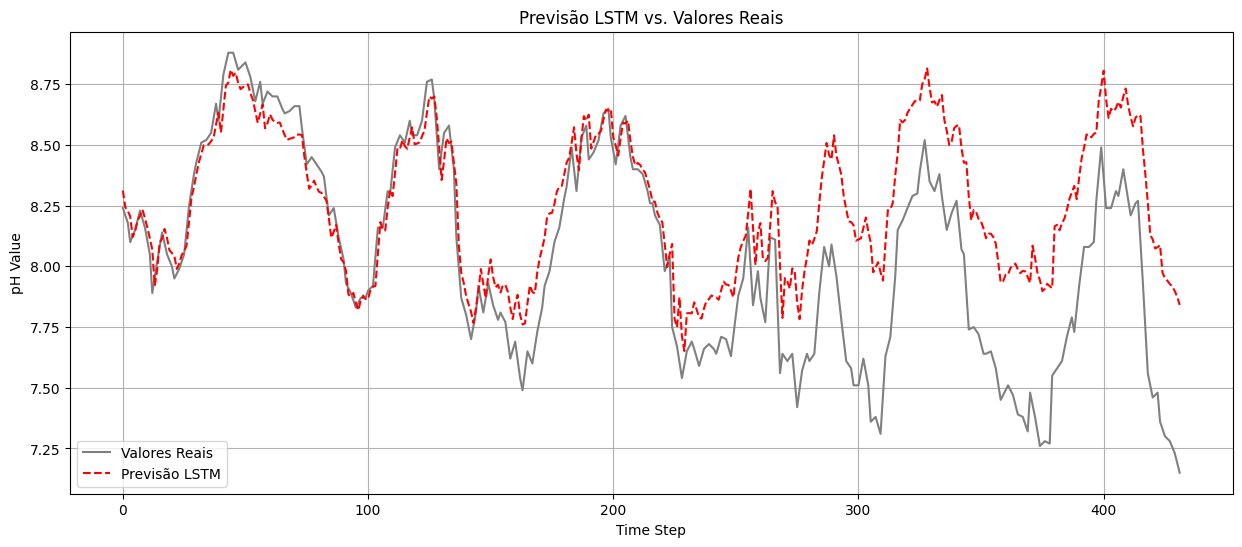

In [7]:
# Calcular o MAE
mae_lstm = mean_absolute_error(true_values, predicted_values)
print(f"\n--- Resultados do Modelo LSTM ---")
print(f"MAE Final no Conjunto de Teste: {mae_lstm:.4f}")

# --- 10. Visualização ---
plt.figure(figsize=(15, 6))
plt.title('Previsão LSTM vs. Valores Reais')
plt.ylabel('pH Value')
plt.xlabel('Time Step')
plt.grid(True)
plt.plot(true_values, label='Valores Reais', color='gray')
plt.plot(predicted_values, label='Previsão LSTM', color='red', linestyle='--')
plt.legend()
plt.show()

Carregando os dados para o modelo Multivariado...
Normalizando todas as features...

Dados preparados para a LSTM Multivariada.
Formato de X_train_multi: torch.Size([4536, 72, 7])

Iniciando o treinamento do modelo LSTM Multivariado...
Época 10/50 - Perda (Loss): 0.134079
Época 20/50 - Perda (Loss): 0.017329
Época 30/50 - Perda (Loss): 0.022794
Época 40/50 - Perda (Loss): 0.017800
Época 50/50 - Perda (Loss): 0.014657
Treinamento concluído em 77.91 segundos.

Iniciando a avaliação no conjunto de teste...

--- Resultados do Modelo LSTM Multivariado ---
MAE Final no Conjunto de Teste: 0.4253


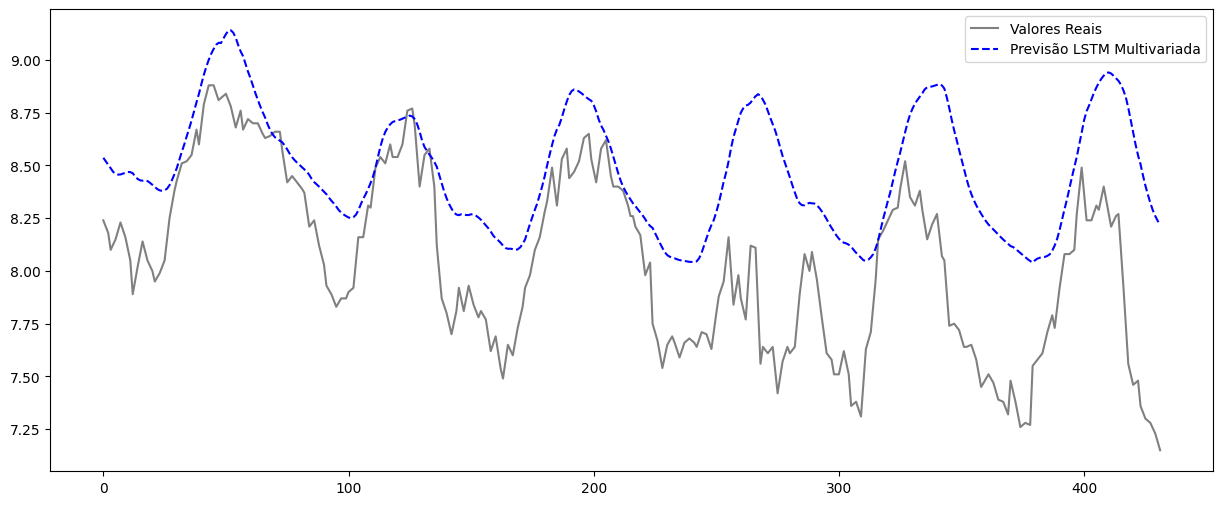

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import time
import matplotlib.pyplot as plt

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando os dados para o modelo Multivariado...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# Selecionar as features que usaremos (incluindo o alvo 'ph')
# Vamos usar as mesmas 6 variáveis exógenas do ARIMAX + o 'ph'
features_to_use = ['ph', 'radiacao', 'orp', 'od', 'te', 'ta', 'tds']
df_multi = df[features_to_use]

# --- 2. Normalização dos Dados ---
print("Normalizando todas as features...")
scaler_multi = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler_multi.fit_transform(df_multi)

# --- 3. Divisão Treino-Teste ---
train_size = len(data_scaled) - (7 * 24 * 3)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# --- 4. Função para Criar Sequências Multivariadas ---
def create_multivariate_sequences(input_data, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        # O input (X) é uma sequência de 'sequence_length' vetores de features
        X.append(input_data[i:(i + sequence_length), :])
        # O alvo (y) é apenas o valor do 'ph' do passo seguinte
        # O 'ph' é a primeira coluna (índice 0)
        y.append(input_data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# --- 5. Criação dos Datasets Finais ---
sequence_length = 72 # Janela de 24 horas
X_train_multi, y_train_multi = create_multivariate_sequences(train_data, sequence_length)
X_test_multi, y_test_multi = create_multivariate_sequences(test_data, sequence_length)

# --- 6. Conversão para Tensores do PyTorch ---
X_train_multi = torch.from_numpy(X_train_multi).float()
y_train_multi = torch.from_numpy(y_train_multi).float().view(-1, 1)
X_test_multi = torch.from_numpy(X_test_multi).float()
y_test_multi = torch.from_numpy(y_test_multi).float().view(-1, 1)

print("\nDados preparados para a LSTM Multivariada.")
print(f"Formato de X_train_multi: {X_train_multi.shape}")

# --- 7. Definição da Nova Arquitetura LSTM ---
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size=X_train_multi.shape[2], hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True) # batch_first=True é mais intuitivo
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        # Pegamos a saída do último passo de tempo para a previsão
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# --- 8. Treinamento do Modelo Multivariado ---
print("\nIniciando o treinamento do modelo LSTM Multivariado...")
start_time = time.time()
model_multi = MultivariateLSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_multi.parameters(), lr=0.001)
epochs = 50 # Menos épocas para começar, pois o treino é mais pesado

for i in range(epochs):
    model_multi.train()
    optimizer.zero_grad()
    y_pred = model_multi(X_train_multi)
    loss = loss_function(y_pred, y_train_multi)
    loss.backward()
    optimizer.step()
    if (i+1)%10 == 0:
        print(f'Época {i+1}/{epochs} - Perda (Loss): {loss.item():.6f}')

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- 9. Avaliação no Conjunto de Teste ---
print("\nIniciando a avaliação no conjunto de teste...")
model_multi.eval()
with torch.no_grad():
    test_predictions_scaled = model_multi(X_test_multi)

# Reverter a normalização das previsões
# Criamos um array "dummy" com o mesmo número de features do scaler
# para reverter apenas a primeira coluna (ph)
dummy_array = np.zeros((len(test_predictions_scaled), len(features_to_use)))
dummy_array[:, 0] = test_predictions_scaled.numpy().flatten()
predicted_values_multi = scaler_multi.inverse_transform(dummy_array)[:, 0]

# Reverter a normalização dos valores reais
dummy_array_true = np.zeros((len(y_test_multi), len(features_to_use)))
dummy_array_true[:, 0] = y_test_multi.numpy().flatten()
true_values_multi = scaler_multi.inverse_transform(dummy_array_true)[:, 0]

# Calcular o MAE
mae_lstm_multi = mean_absolute_error(true_values_multi, predicted_values_multi)
print(f"\n--- Resultados do Modelo LSTM Multivariado ---")
print(f"MAE Final no Conjunto de Teste: {mae_lstm_multi:.4f}")

# --- 10. Visualização ---
plt.figure(figsize=(15, 6))
plt.plot(true_values_multi, label='Valores Reais', color='gray')
plt.plot(predicted_values_multi, label='Previsão LSTM Multivariada', color='blue', linestyle='--')
plt.legend()
plt.show()

Carregando os dados para o modelo Multivariado...
Normalizando todas as features...

Dados preparados para a LSTM Multivariada.
Formato de X_train_multi: torch.Size([4536, 72, 7])

Iniciando o treinamento do modelo LSTM Multivariado...
Época 10/150 - Perda (Loss): 0.028359
Época 20/150 - Perda (Loss): 0.017189
Época 30/150 - Perda (Loss): 0.018084
Época 40/150 - Perda (Loss): 0.016459
Época 50/150 - Perda (Loss): 0.014446
Época 60/150 - Perda (Loss): 0.012960
Época 70/150 - Perda (Loss): 0.011467
Época 80/150 - Perda (Loss): 0.009358
Época 90/150 - Perda (Loss): 0.006297
Época 100/150 - Perda (Loss): 0.003878
Época 110/150 - Perda (Loss): 0.002882
Época 120/150 - Perda (Loss): 0.002148
Época 130/150 - Perda (Loss): 0.001753
Época 140/150 - Perda (Loss): 0.001528
Época 150/150 - Perda (Loss): 0.001400
Treinamento concluído em 233.38 segundos.

Iniciando a avaliação no conjunto de teste...

--- Resultados do Modelo LSTM Multivariado ---
MAE Final no Conjunto de Teste: 0.1661


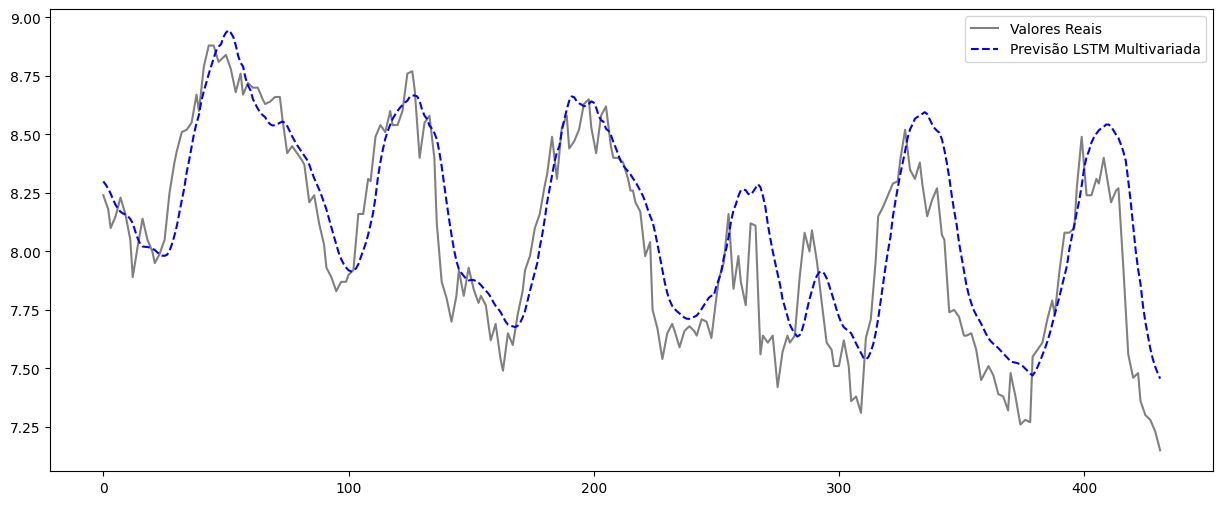

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import time
import matplotlib.pyplot as plt

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando os dados para o modelo Multivariado...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# Selecionar as features que usaremos (incluindo o alvo 'ph')
# Vamos usar as mesmas 6 variáveis exógenas do ARIMAX + o 'ph'
features_to_use = ['ph', 'radiacao', 'orp', 'od', 'te', 'ta', 'tds']
df_multi = df[features_to_use]

# --- 2. Normalização dos Dados ---
print("Normalizando todas as features...")
scaler_multi = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler_multi.fit_transform(df_multi)

# --- 3. Divisão Treino-Teste ---
train_size = len(data_scaled) - (7 * 24 * 3)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# --- 4. Função para Criar Sequências Multivariadas ---
def create_multivariate_sequences(input_data, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        # O input (X) é uma sequência de 'sequence_length' vetores de features
        X.append(input_data[i:(i + sequence_length), :])
        # O alvo (y) é apenas o valor do 'ph' do passo seguinte
        # O 'ph' é a primeira coluna (índice 0)
        y.append(input_data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# --- 5. Criação dos Datasets Finais ---
sequence_length = 72 # Janela de 24 horas
X_train_multi, y_train_multi = create_multivariate_sequences(train_data, sequence_length)
X_test_multi, y_test_multi = create_multivariate_sequences(test_data, sequence_length)

# --- 6. Conversão para Tensores do PyTorch ---
X_train_multi = torch.from_numpy(X_train_multi).float()
y_train_multi = torch.from_numpy(y_train_multi).float().view(-1, 1)
X_test_multi = torch.from_numpy(X_test_multi).float()
y_test_multi = torch.from_numpy(y_test_multi).float().view(-1, 1)

print("\nDados preparados para a LSTM Multivariada.")
print(f"Formato de X_train_multi: {X_train_multi.shape}")

# --- 7. Definição da Nova Arquitetura LSTM ---
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size=X_train_multi.shape[2], hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True) # batch_first=True é mais intuitivo
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        # Pegamos a saída do último passo de tempo para a previsão
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# --- 8. Treinamento do Modelo Multivariado ---
print("\nIniciando o treinamento do modelo LSTM Multivariado...")
start_time = time.time()
model_multi = MultivariateLSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_multi.parameters(), lr=0.001)
epochs = 150 # Menos épocas para começar, pois o treino é mais pesado

for i in range(epochs):
    model_multi.train()
    optimizer.zero_grad()
    y_pred = model_multi(X_train_multi)
    loss = loss_function(y_pred, y_train_multi)
    loss.backward()
    optimizer.step()
    if (i+1)%10 == 0:
        print(f'Época {i+1}/{epochs} - Perda (Loss): {loss.item():.6f}')

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- 9. Avaliação no Conjunto de Teste ---
print("\nIniciando a avaliação no conjunto de teste...")
model_multi.eval()
with torch.no_grad():
    test_predictions_scaled = model_multi(X_test_multi)

# Reverter a normalização das previsões
# Criamos um array "dummy" com o mesmo número de features do scaler
# para reverter apenas a primeira coluna (ph)
dummy_array = np.zeros((len(test_predictions_scaled), len(features_to_use)))
dummy_array[:, 0] = test_predictions_scaled.numpy().flatten()
predicted_values_multi = scaler_multi.inverse_transform(dummy_array)[:, 0]

# Reverter a normalização dos valores reais
dummy_array_true = np.zeros((len(y_test_multi), len(features_to_use)))
dummy_array_true[:, 0] = y_test_multi.numpy().flatten()
true_values_multi = scaler_multi.inverse_transform(dummy_array_true)[:, 0]

# Calcular o MAE
mae_lstm_multi = mean_absolute_error(true_values_multi, predicted_values_multi)
print(f"\n--- Resultados do Modelo LSTM Multivariado ---")
print(f"MAE Final no Conjunto de Teste: {mae_lstm_multi:.4f}")

# --- 10. Visualização ---
plt.figure(figsize=(15, 6))
plt.plot(true_values_multi, label='Valores Reais', color='gray')
plt.plot(predicted_values_multi, label='Previsão LSTM Multivariada', color='blue', linestyle='--')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import time
import matplotlib.pyplot as plt

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando os dados para o modelo Multivariado...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# Selecionar as features que usaremos (incluindo o alvo 'ph')
# Vamos usar as mesmas 6 variáveis exógenas do ARIMAX + o 'ph'
features_to_use = ['ph', 'radiacao', 'orp', 'od', 'te', 'ta', 'tds']
df_multi = df[features_to_use]

# --- 2. Normalização dos Dados ---
print("Normalizando todas as features...")
scaler_multi = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler_multi.fit_transform(df_multi)

# --- 3. Divisão Treino-Teste ---
train_size = len(data_scaled) - (7 * 24 * 3)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# --- 4. Função para Criar Sequências Multivariadas ---
def create_multivariate_sequences(input_data, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        # O input (X) é uma sequência de 'sequence_length' vetores de features
        X.append(input_data[i:(i + sequence_length), :])
        # O alvo (y) é apenas o valor do 'ph' do passo seguinte
        # O 'ph' é a primeira coluna (índice 0)
        y.append(input_data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# --- 5. Criação dos Datasets Finais ---
sequence_length = 72 # Janela de 24 horas
X_train_multi, y_train_multi = create_multivariate_sequences(train_data, sequence_length)
X_test_multi, y_test_multi = create_multivariate_sequences(test_data, sequence_length)

# --- 6. Conversão para Tensores do PyTorch ---
X_train_multi = torch.from_numpy(X_train_multi).float()
y_train_multi = torch.from_numpy(y_train_multi).float().view(-1, 1)
X_test_multi = torch.from_numpy(X_test_multi).float()
y_test_multi = torch.from_numpy(y_test_multi).float().view(-1, 1)

print("\nDados preparados para a LSTM Multivariada.")
print(f"Formato de X_train_multi: {X_train_multi.shape}")

# --- 7. Definição da Nova Arquitetura LSTM ---
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size=X_train_multi.shape[2], hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True) # batch_first=True é mais intuitivo
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        # Pegamos a saída do último passo de tempo para a previsão
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# --- 8. Treinamento do Modelo Multivariado ---
print("\nIniciando o treinamento do modelo LSTM Multivariado...")
start_time = time.time()
model_multi = MultivariateLSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_multi.parameters(), lr=0.001)
epochs = 150 # Menos épocas para começar, pois o treino é mais pesado

for i in range(epochs):
    model_multi.train()
    optimizer.zero_grad()
    y_pred = model_multi(X_train_multi)
    loss = loss_function(y_pred, y_train_multi)
    loss.backward()
    optimizer.step()
    if (i+1)%10 == 0:
        print(f'Época {i+1}/{epochs} - Perda (Loss): {loss.item():.6f}')

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- 9. Avaliação no Conjunto de Teste ---
print("\nIniciando a avaliação no conjunto de teste...")
model_multi.eval()
with torch.no_grad():
    test_predictions_scaled = model_multi(X_test_multi)

# Reverter a normalização das previsões
# Criamos um array "dummy" com o mesmo número de features do scaler
# para reverter apenas a primeira coluna (ph)
dummy_array = np.zeros((len(test_predictions_scaled), len(features_to_use)))
dummy_array[:, 0] = test_predictions_scaled.numpy().flatten()
predicted_values_multi = scaler_multi.inverse_transform(dummy_array)[:, 0]

# Reverter a normalização dos valores reais
dummy_array_true = np.zeros((len(y_test_multi), len(features_to_use)))
dummy_array_true[:, 0] = y_test_multi.numpy().flatten()
true_values_multi = scaler_multi.inverse_transform(dummy_array_true)[:, 0]

# Calcular o MAE
mae_lstm_multi = mean_absolute_error(true_values_multi, predicted_values_multi)
print(f"\n--- Resultados do Modelo LSTM Multivariado ---")
print(f"MAE Final no Conjunto de Teste: {mae_lstm_multi:.4f}")

# --- 10. Visualização ---
plt.figure(figsize=(15, 6))
plt.plot(true_values_multi, label='Valores Reais', color='gray')
plt.plot(predicted_values_multi, label='Previsão LSTM Multivariada', color='blue', linestyle='--')
plt.legend()
plt.show()

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import time
from tqdm import tqdm # Uma biblioteca para mostrar barras de progresso

# --- 1. Carregamento e Preparação dos Dados (como antes) ---
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features # Não vamos fazer o dropna() ainda

df_featured = create_champion_features(df, target_variable='ph')

# --- 2. Divisão Treino-Teste ---
test_size = 7 * 24 * 3 
train_df = df_featured[:-test_size].dropna() # dropna() aqui, após a divisão
test_df_original = df_featured[-test_size:]

FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test_original, y_test_original = test_df_original[FEATURES], test_df_original[TARGET]

# --- 3. Treinar o Modelo Campeão (uma única vez) ---
print("Treinando o modelo RandomForest para o teste de maratona...")
champion_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
champion_model.fit(X_train, y_train)

# --- 4. Pipeline de Previsão Recursiva (A Maratona) ---
print("Iniciando a previsão recursiva de 7 dias (a maratona)...")

# Precisamos de um histórico para começar a previsão
history = y_train.copy()
# As features exógenas do período de teste são "conhecidas"
X_test_exog = X_test_original.drop(columns=[col for col in X_test_original if 'ph_' in col])

predictions_recursive = []

# Usamos tqdm para ver o progresso
for i in tqdm(range(len(X_test_original))):
    # 1. Criar as features de lag e janela para o passo atual
    current_features = []
    # Lags
    for lag in [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]:
        current_features.append(history.iloc[-lag])
    # Janelas
    for window in [2, 4, 8]:
        current_features.append(history.iloc[-window:].mean())
        current_features.append(history.iloc[-window:].std())
        
    # Combinar com as features exógenas do passo atual
    current_exog = X_test_exog.iloc[i].values
    current_input = np.concatenate([current_features, current_exog]).reshape(1, -1)
    
    # 2. Fazer uma única previsão
    current_pred = champion_model.predict(current_input)[0]
    
    # 3. Guardar a previsão
    predictions_recursive.append(current_pred)
    
    # 4. Atualizar o histórico com a NOVA PREVISÃO para o próximo passo
    history = pd.concat([history, pd.Series([current_pred])], ignore_index=True)

# --- 5. Avaliação Final e Justa ---
mae_rf_recursive = mean_absolute_error(y_test_original, predictions_recursive)
print(f"\n--- Resultado da Avaliação Justa (Recursiva) ---")
print(f"MAE Final do RandomForest (Maratona de 7 dias): {mae_rf_recursive:.4f}")
print(f"MAE Final do ARIMAX (Maratona de 7 dias): 0.3347")

Treinando o modelo RandomForest para o teste de maratona...
Iniciando a previsão recursiva de 7 dias (a maratona)...


C:\Users\User\anaconda3\envs\doc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\doc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\doc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\doc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\doc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fit


--- Resultado da Avaliação Justa (Recursiva) ---
MAE Final do RandomForest (Maratona de 7 dias): 1.6479
MAE Final do ARIMAX (Maratona de 7 dias): 0.3347


In [12]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm # Uma biblioteca para mostrar barras de progresso

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features

df_featured = create_champion_features(df, target_variable='ph')

# --- 2. Divisão Treino-Teste ---
test_size = 7 * 24 * 3 
train_df = df_featured[:-test_size].dropna()
test_df_original = df_featured[-test_size:]

FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test_original, y_test_original = test_df_original[FEATURES], test_df_original[TARGET]

# --- 3. Treinar o Modelo Otimizado (LightGBM) ---
print("Treinando o modelo LightGBM otimizado para o teste de maratona...")
# Usamos os melhores hiperparâmetros que encontrámos
best_lgbm = lgb.LGBMRegressor(
    objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42,
    learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0
)
best_lgbm.fit(X_train, y_train, eval_set=[(X_test_original, y_test_original)], callbacks=[lgb.early_stopping(100, verbose=False)])

# --- 4. Pipeline de Previsão Recursiva (A Maratona) ---
print("Iniciando a previsão recursiva de 7 dias (a maratona) com LightGBM...")

history = y_train.copy()
X_test_exog = X_test_original.drop(columns=[col for col in X_test_original if 'ph_' in col])
predictions_recursive_lgbm = []

for i in tqdm(range(len(X_test_original))):
    # 1. Criar as features de lag e janela para o passo atual
    current_features_values = []
    # Lags
    for lag in [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]:
        current_features_values.append(history.iloc[-lag])
    # Janelas
    for window in [2, 4, 8]:
        current_features_values.append(history.iloc[-window:].mean())
        current_features_values.append(history.iloc[-window:].std())
        
    # Combinar com as features exógenas
    current_exog_values = X_test_exog.iloc[i].values
    current_input_values = np.concatenate([current_features_values, current_exog_values]).reshape(1, -1)
    
    # #############################################################################
    # CORREÇÃO PARA EVITAR O UserWarning
    # Convertemos o array do NumPy de volta para um DataFrame com os nomes corretos
    # #############################################################################
    current_input_df = pd.DataFrame(current_input_values, columns=X_train.columns)
    
    # 2. Fazer uma única previsão
    current_pred = best_lgbm.predict(current_input_df)[0]
    
    # 3. Guardar a previsão
    predictions_recursive_lgbm.append(current_pred)
    
    # 4. Atualizar o histórico com a NOVA PREVISÃO
    history = pd.concat([history, pd.Series([current_pred])], ignore_index=True)

# --- 5. Avaliação Final e Justa ---
mae_lgbm_recursive = mean_absolute_error(y_test_original, predictions_recursive_lgbm)
print(f"\n--- Resultado da Avaliação Justa (Recursiva) ---")
print(f"MAE Final do LightGBM (Maratona de 7 dias): {mae_lgbm_recursive:.4f}")
print(f"MAE Final do ARIMAX (Maratona de 7 dias): 0.3347")

Carregando e preparando os dados...
Treinando o modelo LightGBM otimizado para o teste de maratona...
Iniciando a previsão recursiva de 7 dias (a maratona) com LightGBM...


100%|███████████████████████████████████████████████████████████████████████████████| 504/504 [00:01<00:00, 461.68it/s]


--- Resultado da Avaliação Justa (Recursiva) ---
MAE Final do LightGBM (Maratona de 7 dias): 1.5783
MAE Final do ARIMAX (Maratona de 7 dias): 0.3347


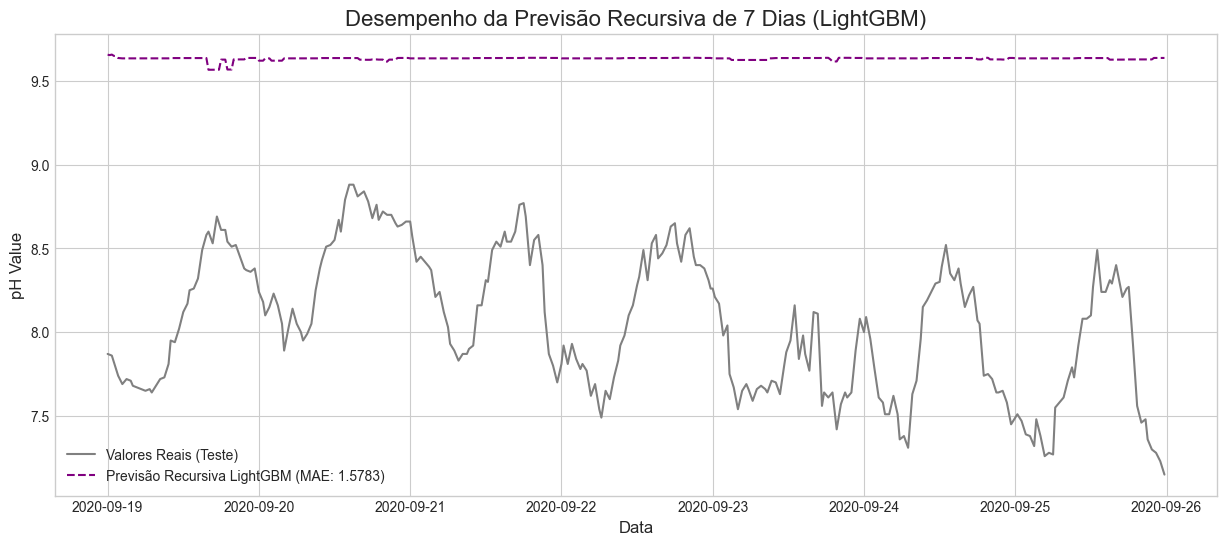

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Assumimos que 'y_test_original' e 'predictions_recursive_lgbm' existem na memória ---
# y_test_original: Os valores reais do conjunto de teste
# predictions_recursive_lgbm: As previsões que acabámos de gerar

# --- Visualização da Previsão Recursiva do LightGBM ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(y_test_original.index, y_test_original, label='Valores Reais (Teste)', color='gray', linewidth=1.5)
ax.plot(y_test_original.index, predictions_recursive_lgbm, label=f'Previsão Recursiva LightGBM (MAE: {mae_lgbm_recursive:.4f})', color='purple', linestyle='--')

ax.set_title('Desempenho da Previsão Recursiva de 7 Dias (LightGBM)', fontsize=16)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('pH Value', fontsize=12)
ax.legend()

# Salvando a figura (ajuste o caminho se necessário)
# output_path = ...
# plt.savefig(output_path, dpi=300)

plt.show()